In [104]:
import os
from dotenv import load_dotenv
from pprint import pprint
import base64
import json
import mimetypes
import os
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [105]:
## access to API key
 
notebook_directory = os.getcwd()

# Construct the absolute path to the api.env file
env_file_path = os.path.join(notebook_directory, "api.env")

# Load environment variables from the api.env file
load_dotenv(env_file_path)

# Access the API key
api_key = os.getenv("OPENAI_API_KEY")

In [106]:
# !setx OPENAI_API_KEY api_key

os.environ['OPENAI_API_KEY'] = api_key

In [107]:
def encode_image(image_path: str):
    """Encodes an image to base64 and determines the correct MIME type."""
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        raise ValueError(f"Cannot determine MIME type for {image_path}")

    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        return f"data:{mime_type};base64,{encoded_string}"


def create_payload(images: list[str], prompt: str, model="gpt-4-vision-preview", max_tokens=100, detail="high"):
    """Creates the payload for the API request."""
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        },
    ]

    for image in images:
        base64_image = encode_image(image)
        messages[0]["content"].append({
            "type": "image_url",
            "image_url": {
                "url": base64_image,
                "detail": detail,
            }
        })

    return {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens
    }


def query_openai(payload):
    """Sends a request to the OpenAI API and prints the response."""
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

In [108]:
# image_paths = ["C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/StanfordJpegs/item57221724.jpg"]
# prompt = "describe the fashion item with one sentence"
# payload = create_payload(image_paths, prompt)
# response = query_openai(payload)
# print(response)
# print(rs[0]['message']['content'])

In [109]:
file_path = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/ThredupData.csv"
df = pd.read_csv(file_path)

# Remove images from the dataframe that are not present in the folder

# get images downloaded
downloaded_files = os.listdir("data/StanfordJpegs/")

# # apply labels to the dataset
df['filename'] = df['Item_Id'].apply(lambda x: 'item' + str(x))
df['is_downloaded'] = df['filename'].apply(lambda x: True if x in downloaded_files else False)



In [69]:
# remove items that didn't get downloaded and  value counts <120 and >300
cat_counts = df['Category_Type'].value_counts()
valid_cat_h = cat_counts[cat_counts>120].index.to_list()
valid_cat_l = cat_counts[cat_counts<300].index.to_list()
df_load = df[(df['is_downloaded'] == True) & (df['Category_Type'].isin(valid_cat_h)) & (df['Category_Type'].isin(valid_cat_l))].copy()

# remove the replicated categories causal pants and khakis
df_load = df_load[~df_load['Category_Type'].isin(['Casual Pants', 'Khakis'])] 

categories = df_load['Category_Type'].unique()
len_categories = len(categories)
print(f'the number of valid item categories: {len_categories}')

#create a mapping
cat_to_int = {item:idx for idx, item in enumerate(categories)}
int_to_cat = {idx:item for idx, item in enumerate(categories)}

df_load['labels'] = df_load['Category_Type'].apply(lambda x: cat_to_int[x])
# pull only filename and label
df_load = df_load[['filename','labels']]
df_load.head()

the number of valid item categories: 7


,filename,labels
0,item110746148,0
1,item111845154,0
2,item111894473,0
3,item111978980,0
4,item112127758,0


In [111]:
# Split the DataFrame into training and testing sets considering each label category
train_df, test_df = train_test_split(df_load, test_size=0.1, stratify=df_load['labels'], random_state=42)
len(test_df)

151

In [112]:
def read_save_image(filename):
    # Define the base directory for your images
    base_dir = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/StanfordJpegs/"
    
    # Construct the full image path
    image_path = os.path.join(base_dir, filename)

    # Open the image
    img = Image.open(image_path)

    # Define the output directory for JPEGs
    output_dir = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/StanfordJpegs/jpeg_folder/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Construct the output path
    output_path = os.path.join(output_dir, filename + '.jpg')

    # Save the image as a JPEG file
    img.save(output_path, 'JPEG')

    return output_path

In [113]:
# Create a list to store the paths of the JPEG images
image_paths = []

# Iterate over the test DataFrame
for filename in test_df['filename']:
    # Save each image as JPEG and get the path
    jpeg_path = read_save_image(filename)
    image_paths.append(jpeg_path)


In [99]:
selected_image_paths = image_paths[:2]

# Create the payload with the selected images
prompt = "describe the fashion item with one sentence including all salient details such as material, shape, fit, color, era, style and anything else relevant for shopping" #in terms of shape, fit and details
# payload = create_payload(selected_image_paths, prompt)

# # Query the OpenAI API with your payload
# response = query_openai(payload)
# print(response)

In [90]:
rs=response['choices']
print(rs[0]['message']['content'])

The first item is a burgundy chiffon blouse with sheer sleeves and a V-neckline, while the second is a classic black suede pump with a mid-height heel and studded detailing.


In [117]:
selected_image_paths = image_paths

# Assuming image_paths is already populated
responses = []

for img_path in selected_image_paths:
    # Create payload for each image
    payload = create_payload([img_path], prompt)

    # Query the OpenAI API
    response = query_openai(payload)

    # Extract the relevant part of the response
    description = response['choices'][0]['message']['content']
    
    # Store the response and corresponding filename
    responses.append({
        "filename": os.path.basename(img_path),
        "description": description
    })

# Convert the responses list to a DataFrame
responses_df = pd.DataFrame(responses)

# Specify the filename
csv_filename = 'item_descriptions.csv'

# Save to CSV
responses_df.to_csv(csv_filename, index=False)

In [116]:
# Print or process the responses
for item in responses[:2]:
    print(f"Filename: {item['filename']}\nDescription: {item['description']}\n")

Filename: item108153495.jpg
Description: This is a burgundy women's blouse featuring a sheer chiffon fabric, with a flowing silhouette, long sleeves, and a V-neckline, likely contemporary and versatile for casual to semi-formal events.

Filename: item112414117.jpg
Description: The item is a classic black suede pump featuring a rounded toe, mid-height tapered heel, and a subtle studded detail along the upper's edge, evoking a timeless, versatile style suitable for various occasions.



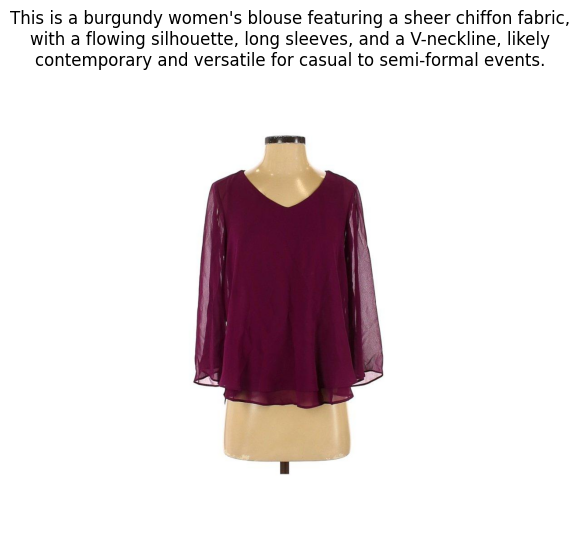

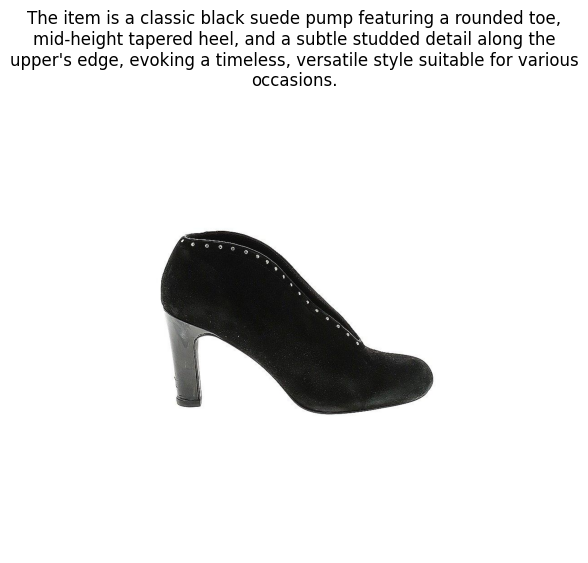

: 

In [118]:
# Base directory of your images
output_dir = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/StanfordJpegs/jpeg_folder/"

# Iterate over the responses and display each image with its description
for item in responses[:2]:
    img_path = os.path.join(output_dir, item["filename"])

    # Open the image
    img = Image.open(img_path)

    # Set up the matplotlib figure
    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks

    # Display the description
    plt.title(item["description"], wrap=True)

    # Show the plot
    plt.show()